# This notebook is for drafting Grovers algorithms using qiskit.
In the future, replace the static oracle with our own that implements the configuration problem

In [27]:
# Imports
# initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info.operators import Operator
import qiskit.compiler as qispiler

# import basic plot tools
from qiskit.visualization import plot_histogram

Initialization function for bringing qubits into superposition using Hadamard.

In [6]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

Next, we create a function to create an oracle quantum circuit given the number of qubits and solution states.

An example oracle matrix for eight qubits, marking the last one to be phase flipped (correct answer) looks like the following:
```
oracle_matrix = [[1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, -1]]
```

In [7]:
def create_oracle(nqubits, solutions):
    """ Create an identity matrix of size nqubits and flip phase of solutions"""
    I = Operator([[1,0],[0,1]])
    unitary = I
    for i in range(nqubits-1):
        unitary = unitary.tensor(I)
    
    for s in solutions:
        index = 0
        for i in range(nqubits):
            index += (2**i)*s[nqubits-i-1]
        unitary.data[index][index] = -1
    return unitary 

Let's define our quantum circuit size and solutions now:

In [8]:
nqubits = 8
qc = QuantumCircuit(nqubits)
solutions = [[1,0,0,1,1,0,0,1],[1,0,0,1,1,1,0,1]] # Two solutions

With this input, we can determine the amount of iterations we need to run the oracle-diffuser sequence of Grover.

In [11]:
N = 2**nqubits                                  # Search Space Size
M = len(solutions)                              # Number of Solutions
theta = math.asin(2*math.sqrt(M*(N-M))/N)       # Initial angle between "good vector" and "bad vector"
k = round(math.acos(math.sqrt(M/N))/theta)      # Number of Grover iterations
print(f"Number of iterations: {k}")

Number of iterations: 8


We can now create our **Oracle** using the function defined above:

In [14]:
qc.unitary(create_oracle(nqubits,solutions), range(nqubits), label="oracle")

Using the qiskit transpiler we can visualize how our oracle looks:

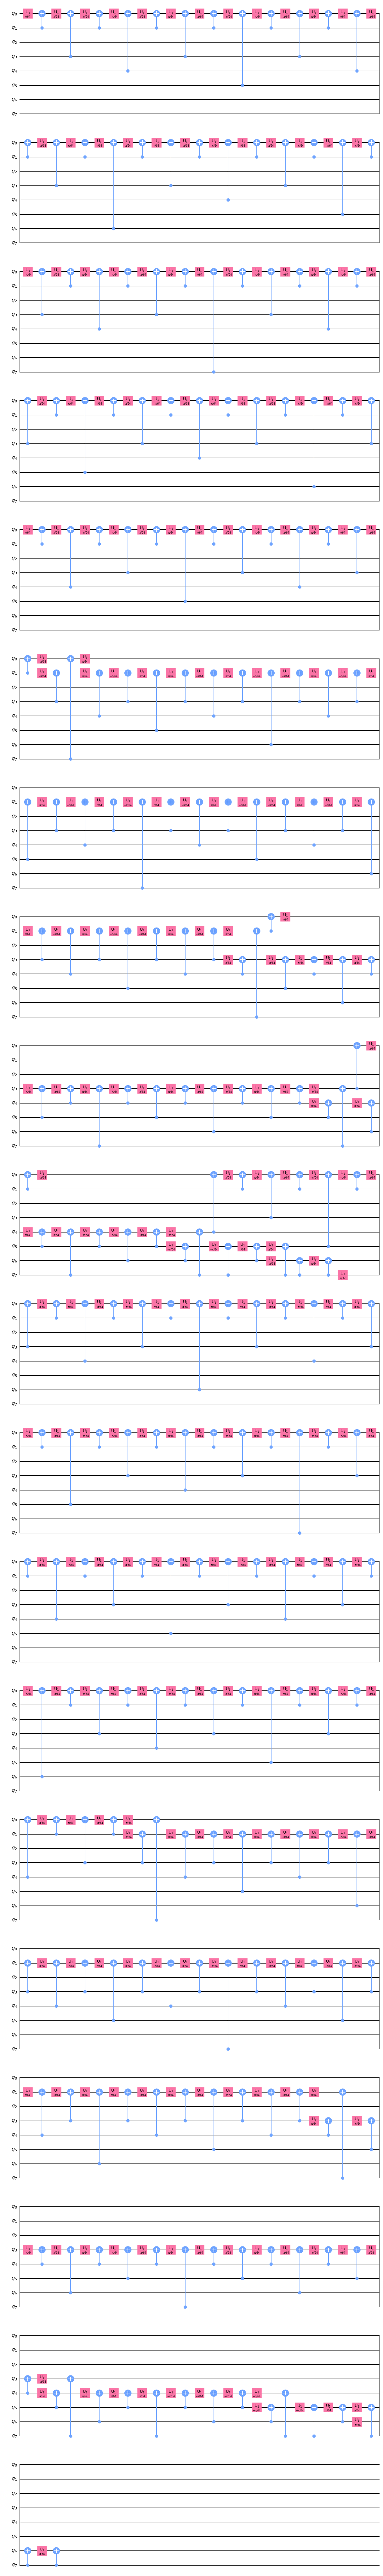

In [18]:
gate_set_nairobi = ['h', 'cx', 'id', 'rz', 'sx', 'x'] # a gate set plus hadamard
gate_set_default = ['h', 'u1', 'u2', 'u3', 'cx']      # the default gate set
backend = Aer.get_backend('aer_simulator_stabilizer')
qcd = qispiler.transpile(qc, basis_gates=gate_set_default, optimization_level=3)
# qcd = qispiler.transpile(qc, backend=backend, optimization_level=3)
qcd.draw(output="mpl")

Take the predefiend function from qiskit textbooks to create a diffuser circuit:

In [19]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_{Diffuser}$"
    return U_s

### Full Grover Circuit
Now we can stick all parts together into a single Grover Algorithm

<IPython.core.display.Javascript object>


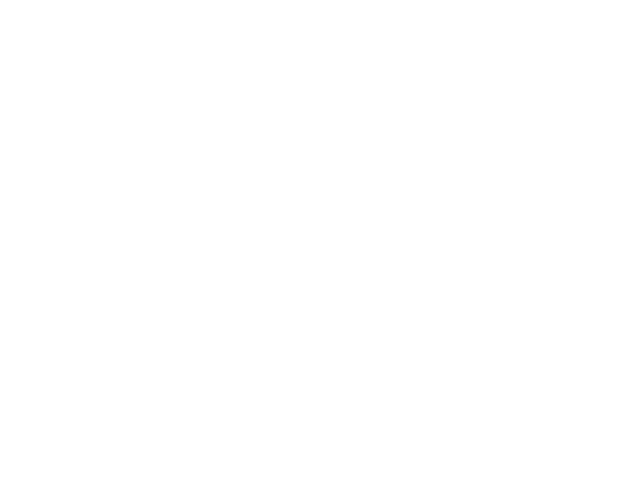

<IPython.core.display.Javascript object>


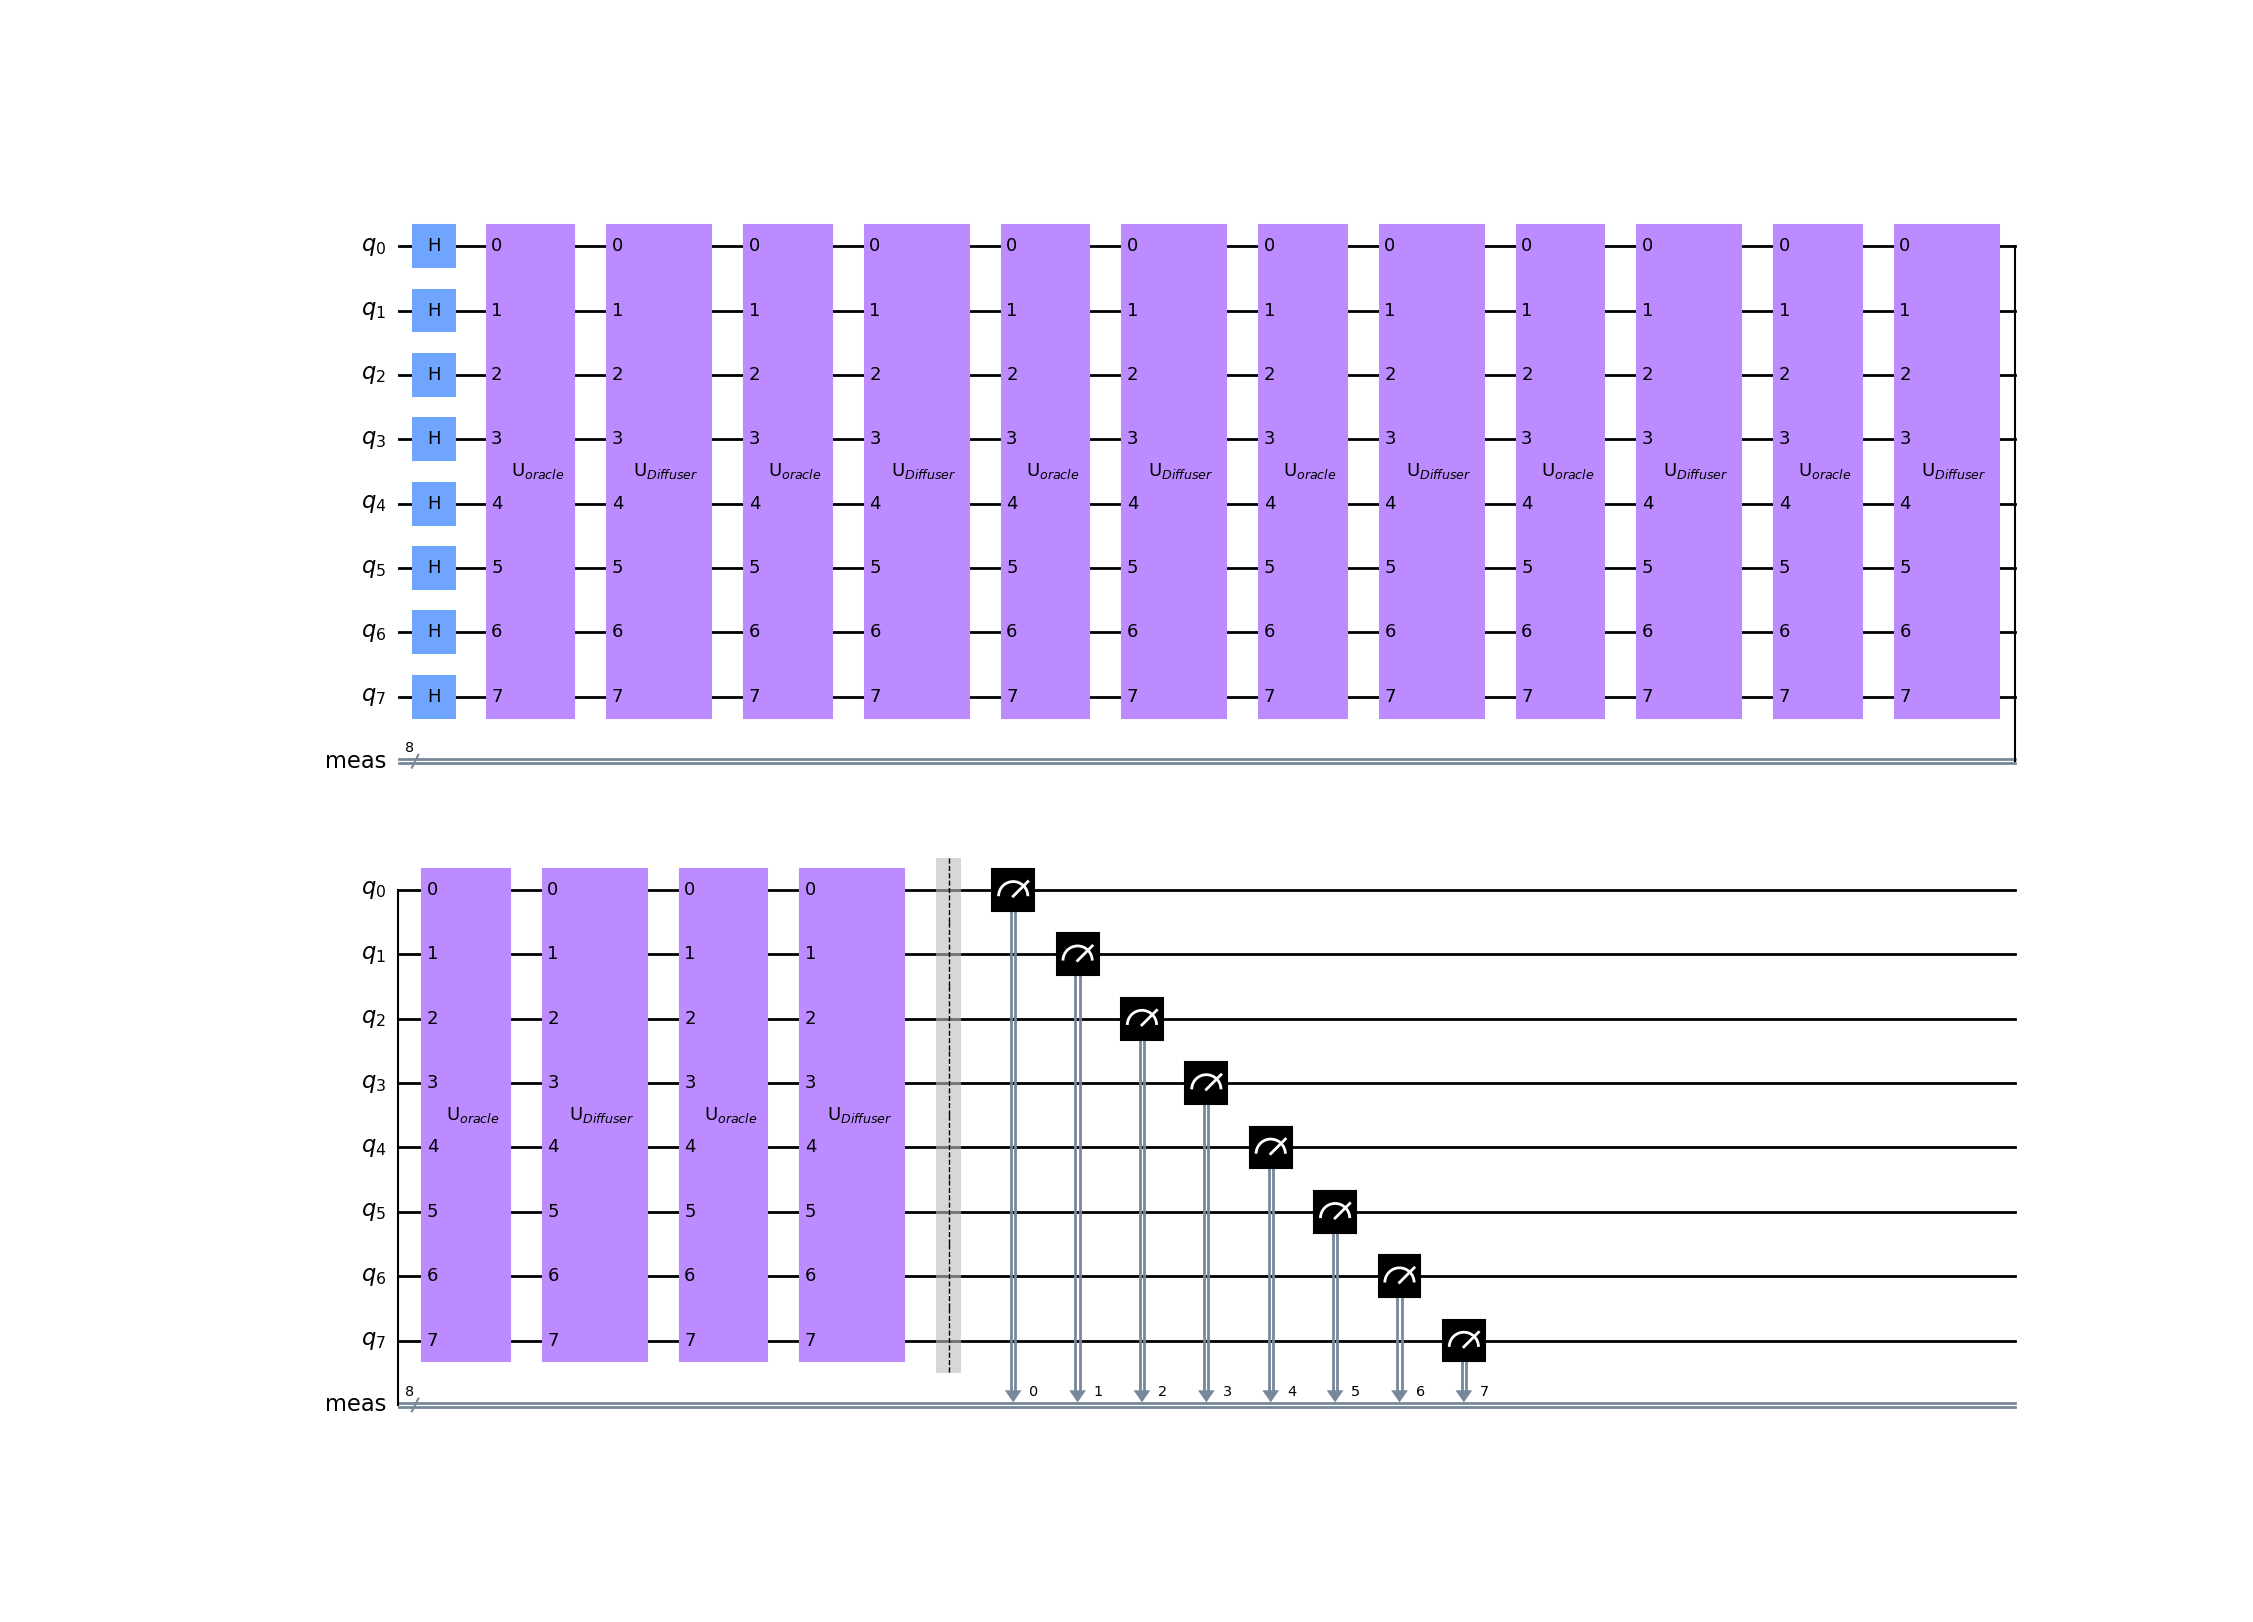

In [25]:
grover_circuit = QuantumCircuit(nqubits)
grover_circuit = initialize_s(grover_circuit, range(nqubits))

# Add the oracle-diffusor step k times
for i in range(k):
    grover_circuit.append(oracle_ex3, range(nqubits))
    grover_circuit.append(diffuser(nqubits), range(nqubits))

grover_circuit.measure_all()
grover_circuit.draw(output="mpl")

### Simulate the circuit

<IPython.core.display.Javascript object>


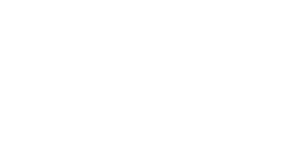

<IPython.core.display.Javascript object>


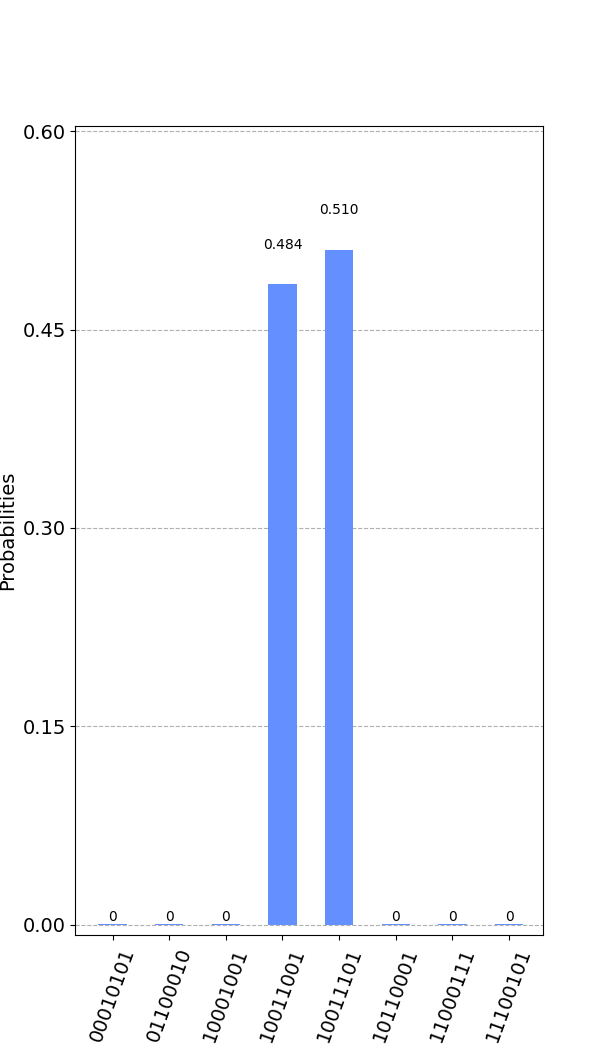

In [28]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
histogram = plot_histogram(counts)
histogram # For display purposes in jupyter